# Surname Classification Using a Character RNN


### Instead of building a RNN model using the RNNCell, use built-in RNNs: nn.RNN, nn.LSTM, and nn.GRU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Vocabulary, Vectorizer, Dataset

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """
        # _token_to_idx for char_vocab:
        #   {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'T': 4, 'o': 5, 't': 6, 'a': 7, ....., 'Á': 79}
        # _idx_to_token:
        #   {0:'<MASK>'0, 1:'<UNK>', 2:'<BEGIN>',   3:'<END>',   4:'T',  5:'o',  6:'t',  7:'a',....., 79:'Á'}

        # _token_to_idx nationality_vocab: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
        # _idx_to_token:                   {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [4]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token  # for paddding, e.g., 'McMahan' -> [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)           # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)             # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token) # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)     # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [5]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            surname (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # SurnameDataset._max_seq_length is 19 in current dataset.
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        """
        mask_index is 0
        unk_index is 1
        begin_seq_index is 2
        end_seq_index is 3

        When surname is "McMahan", M=5,c=6, a=7, h=8, and n=9

        out_vector = [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0]
        len(indices) = 9
        """

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary() # add mask, unknown, begin_seq, and end_seq tokens to the token_to_index dictionary
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [6]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2   # add 2 for begin_seq_token and end_seq_token

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()   # {'English': 2972, 'Russian': 2373, ....}
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0]) # e.g, index of English is 4
        sorted_counts = sorted(class_counts.items(), key=sort_key)          # sort by the index number of nationality_vocab
                                   # {('Arabic', 1603), ('Chinese', 220), ('Czech', 414), ('Dutch', 236),('English', 2972), ...}
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) # [1/1603, 1/220, 1/414, 1/236, 1/2972, ...]


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,      # 'x_data': [2, 5, 6, 5, 7, 8, 7, 9, 3, 0, 0, 0, ..., 0],when surname is "McMahan"
                'y_target': nationality_index, # 'y_target': 4
                'x_length': vec_length}        # 'x_length': 9

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Model

In [38]:

def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1   # deduct 1 since the index starts from 0
                                                              # e.g., [9, 6, 11, 9, 7, ...., 12]
    out = []
    for batch_index, column_index in enumerate(x_lengths): # out gets the last hidden vector of each input: (batch, hidden_size)
        out.append(y_out[batch_index, column_index]) # e.g., y_out[0, 9], y_out[1, 6]

    return torch.stack(out)  # (batch, hidden_size*num_directions); E.g., (64, 64*num_direction)

def column_summation(y_out, x_lengths, mode="mean"):
    '''Get a max or mean vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by
    the position indicated by the corresponding value in `x_lengths` at the row index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        mode: "mean" for mean vector; "max" for max vector

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        if mode == "mean":
            # replace "pass" with your code to get the mean vector of current batch item from y_out[], and append it to out list.
            pass
        else:      # mode == "max"
            # replace "pass" with your code to get the max vector of current batch item from y_out[], , and append it to out list.
            pass

    return torch.stack(out)

class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, bidirectional=False, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            bidirectional (bool): Informs whether bidrectional RNN is used
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        if bidirectional == False:
             self.num_directions = 1
        else:
             self.num_directions = 2

        self.emb = nn.Embedding(num_embeddings=num_embeddings,    # E.g., (80, 100)
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)          # mask_index (padding index) is 0

        # self.rnn = nn.RNN(input_size=embedding_size,              # E.g., 100
        # self.rnn = nn.GRU(input_size=embedding_size,
        self.rnn = nn.LSTM(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,         # E.g., 64
                             batch_first=batch_first,
                             num_layers = 1,
                             dropout = 0.0,
                             bidirectional=bidirectional)

        self.fc1 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,  # 64*1 for unidirectinal; 64*2 for bidirectional
                         out_features=rnn_hidden_size*self.num_directions)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size*self.num_directions,
                          out_features=num_classes)                            # 18 classes
        # for batch norm
        self.bn1 = nn.BatchNorm1d(rnn_hidden_size*self.num_directions)


    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim, i.e. seq_size)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence: (batch,)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)      # (batch, seq_size)->(batch, seq_size, feat_size) ; E.g., (64,19)->(64,19,100)

        y_out, _ = self.rnn(x_embedded)  # (batch, seq_size, feat_size) -> (batch, seq_size, hidden_size*num_directions)
                                         # (64,19,100) -> (64,19,64*num_directions)

        if x_lengths is not None:        # (batch, ) ; e.g., (64,) ; e.g., [9, 6, 11, 9, 7, ...., 12]
            y_out = column_gather(y_out, x_lengths)  # y_out gets the last hidden vector of each input: (batch, hidden_size*num_directions)
                                                     # (64, 64*num_direction)
                                                     # but, the last hidden vector of last character, not including padding
                                                     # e.g., get the last hidden vetor from y_out[batch_no, 9] instead of y_out[batch_no, 18].

            # uncomment code below for task 2, and comment out the line above.
            # y_out gets the max or mean hidden vector of each input
            #y_out = column_summation(y_out, x_lengths, mode="max")
        else:
            y_out = y_out[:, -1, :]      # y_out gets the last hidden vector of each input: (batch, hidden_size*num_directions)
                                         # (64, 64*num_direction)

        # with batch norm and dropout
        y_out = F.relu(self.bn1(self.fc1(F.dropout(y_out, 0.2, training=self.training))))  # y_out: (64, 64*num_direction)


        # with dropout
        y_out = self.fc2(F.dropout(y_out, 0.2, training=self.training))   # y_out: (batch, num_classes) ; (64, 18)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

## Settings

In [111]:
args = Namespace(
    # Data and path information
    surname_csv="/content/drive/MyDrive/wk8-rnn-chapter_6/wk8-rnn-chapter_6/data/surnames/surnames_with_splits.csv",
    model_state_file="model.pth",
    save_dir="/content/drive/MyDrive/wk8-rnn-chapter_6/wk8-rnn-chapter_6/model_storage/ch6/surname_classification",
    # Model hyper parameter
    char_embedding_size=200,
    rnn_hidden_size=512,
    bidirectional=False,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: False


In [40]:
# create dataset and vectorizer
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index,
                               bidirectional=args.bidirectional)

In [41]:
dataset._max_seq_length # max sequence length

19

In [42]:
vectorizer.char_vocab._token_to_idx

{'<MASK>': 0,
 '<UNK>': 1,
 '<BEGIN>': 2,
 '<END>': 3,
 'H': 4,
 'a': 5,
 'd': 6,
 'M': 7,
 'l': 8,
 'o': 9,
 'f': 10,
 'S': 11,
 'e': 12,
 'i': 13,
 'm': 14,
 'n': 15,
 'T': 16,
 'u': 17,
 's': 18,
 'r': 19,
 'D': 20,
 'b': 21,
 'K': 22,
 'h': 23,
 'k': 24,
 'B': 25,
 'N': 26,
 'A': 27,
 'w': 28,
 'R': 29,
 'c': 30,
 'Z': 31,
 'g': 32,
 'y': 33,
 't': 34,
 'z': 35,
 'G': 36,
 'W': 37,
 'I': 38,
 'F': 39,
 'E': 40,
 'C': 41,
 'Q': 42,
 'j': 43,
 'Y': 44,
 'X': 45,
 'p': 46,
 'J': 47,
 'L': 48,
 'O': 49,
 '-': 50,
 ':': 51,
 'P': 52,
 'U': 53,
 '1': 54,
 'v': 55,
 'V': 56,
 'x': 57,
 '/': 58,
 'q': 59,
 'É': 60,
 'é': 61,
 "'": 62,
 'ê': 63,
 'ç': 64,
 'ü': 65,
 'ö': 66,
 'ä': 67,
 'ß': 68,
 'ú': 69,
 'ó': 70,
 'ò': 71,
 'à': 72,
 'è': 73,
 'ì': 74,
 'ù': 75,
 'ł': 76,
 'Ś': 77,
 'ą': 78,
 'ń': 79,
 'Ż': 80,
 'á': 81,
 'ã': 82,
 'í': 83,
 'ñ': 84}

In [43]:
vectorizer.nationality_vocab._token_to_idx

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

## Training Routine

In [44]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        #if loss_t >= loss_tm1: # if current loss becomes smaller than the previous loss, early_stopping_step is reset to 0.
                                # this statement makes the model training time longer, compared to the statement below.
        if loss_t >= train_state['early_stopping_best_val']:  # curent loss is compared with early_stopping_best_val loss value
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [112]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'],         # (batch, seq_size) ; e.g., (64,19)
                                x_lengths=batch_dict['x_length'])  # (batch,) ; e.g, (64,)
                                                                   # y_pred: (batch, num_classes) ; e.g., (64,18)
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])

            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'],
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 1
        val_bar.n = 1
        epoch_bar.update()

        if train_state['stop_early']:
            break

except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

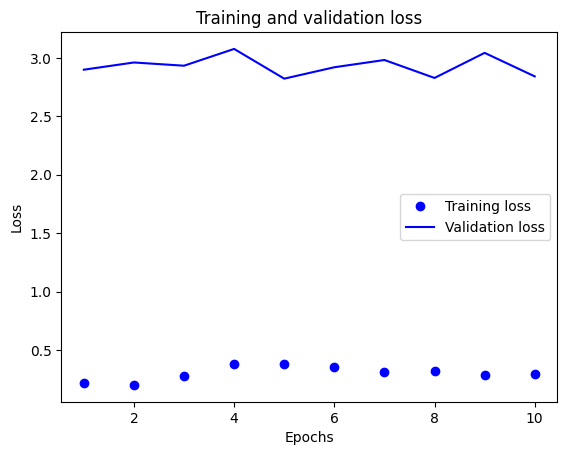

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

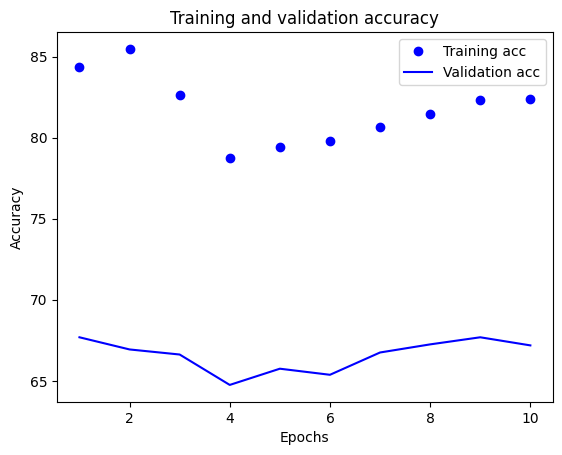

In [114]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [115]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'],weights_only=False))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []         # store predicted values for confusion matrix
y_nationality_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])

    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
    y_nationality_list.extend(batch_dict['y_target'].cpu().numpy())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [116]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.9047685003280646;
Test Accuracy: 67.3125


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
nationality_classes = []
for i in range(len(dataset._vectorizer.nationality_vocab)):
    nationality_classes.append(dataset._vectorizer.nationality_vocab.lookup_index(i))
print(nationality_classes)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [ ]:
import pandas as pd
cm = confusion_matrix(y_nationality_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=nationality_classes, columns=nationality_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True        Arabic  Chinese  Czech  Dutch  English  French  German  Greek  \
Predicted                                                                   
Arabic         211        0      2      1       24       2       3      1   
Chinese          0        9      0      1        1       0       1      0   
Czech            0        0     21      1       10       0       0      0   
Dutch            0        0      5     15       33       3      13      0   
English          0        0      4      1       73       2       4      0   
French           3        0      1      3       45      16       6      0   
German           0        0      4      8       59       1      47      0   
Greek            3        0      3      0        5       1       1     21   
Irish            0        1      1      1       43       4       2      0   
Italian          5        0      0      0        3       2       0      0   
Japanese         4        1      1      0        8       0       2      0   

In [ ]:
print(classification_report(y_nationality_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       231
           1       0.43      0.28      0.34        32
           2       0.41      0.33      0.37        63
           3       0.20      0.43      0.27        35
           4       0.79      0.17      0.28       429
           5       0.17      0.46      0.25        35
           6       0.36      0.56      0.44        84
           7       0.51      0.91      0.66        23
           8       0.19      0.56      0.28        27
           9       0.64      0.61      0.63        85
          10       0.76      0.85      0.80       113
          11       0.23      0.58      0.33        12
          12       0.26      0.50      0.35        18
          13       0.00      0.00      0.00         9
          14       0.96      0.69      0.80       347
          15       0.06      0.67      0.11        12
          16       0.33      0.38      0.35        37
          17       0.12    

### Inference

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [ ]:
# surname = input("Enter a surname: ")
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Kim']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'Irish', 'probability': 0.9877168536186218, 'surname': 'McMahan'}
{'nationality': 'Japanese', 'probability': 0.9663277268409729, 'surname': 'Nakamoto'}
{'nationality': 'Chinese', 'probability': 0.5624672770500183, 'surname': 'Wan'}
{'nationality': 'Korean', 'probability': 0.9691554307937622, 'surname': 'Kim'}


# Lab Assignment #2: due on 2 April, 2025

- ### Task 1: Build the best model (based on test loss and test accuracy) by exploring following hyperparameters in three types of RNNs (nn.RNN, nn.LSTM, and nn.GRU):
  1. input_size (i.e. args.char_embedding_size)
  2. hidden_size (i.e. arg.rnn_hidden_size)
  3. Note that it is not necessary to adjust other hyperparameter values even though you are allowed to do so.
<br><br>

- ### Task 2: Modify the <b>original</b> RNN model using following approaches.
  - In forward() function in code cell [9] (note that the code cell numbers may change if you rerun the code.), column_gather() returns a specific vector from each batch datapoint in `y_out`. More precisely, iterate over batch row indices, get the vector that's at the position indicated by the corresponding value in `x_lengths` at the row index.
  > y_out = column_gather(y_out, x_lengths)
  
  - Modify code to get the max or mean vector of all the vectors by the position indicated by the corresponding value in `x_lengths` by using the following command.
  > y_out = column_summation(y_out, x_lengths, mode="max")  # mode is either max or mean
  - Complete column_summation() function in code cell [9] by adding necessary statements to it. column_summation() returns a max or mean vector from each batch datapoint in `y_out`. More precisely, iterate over batch row indices, get the max or mean vector of all the vectors by the position indicated by the corresponding value in `x_lengths` at the row index (i.e., when calculating the max or mean vector, ignore the hidden state vectors generated with padding input tokens). Refer to column_gather() in code cell [9] and [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html#torch.mean) and [torch.max](https://pytorch.org/docs/stable/generated/torch.max.html?highlight=torch+max#torch.max).
  > Hint:<br>
  > out.append(y_out[ ....select hidden state vectors from each batch datapoint.... ].mean(dim=0))  # to get the mean vector:  <br>
  > <br>
  > out.append(y_out[ ....select hidden state vectors from each batch datapoint.... ].max(dim=0).values)  # to get the max vector:  <br>
  > <br>
  - Try to explore whether the <b>original</b> RNN model improves with column_summation(y_out, x_lengths, mode="max") and column_summation(y_out, x_lengths, mode="mean") options.

- ### Write a report in Word or PDF that summarizes your solutions to Tasks 1 and 2, and discuss your observations, such as test result changes with your solutions (up to 2 pages).

- ### Submit one zip file, named __lab-assign-no2-yourname.zip__, that contains 2 Jupyter Notebook files (one for each Task), input data files, and a report file through Turnitin on the class website.

- ### Each Jupyter notebook file must show all output results of your best model. So please make sure that you run all the cells in the notebook file before your submission. Also note that Turnitin does not allow you to resubmit your lab assignment file.
